## load data

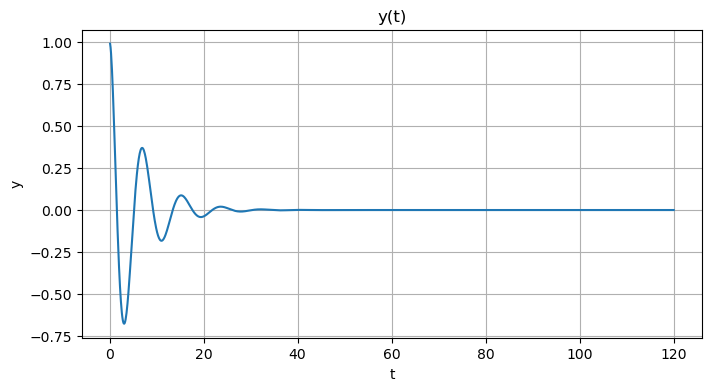

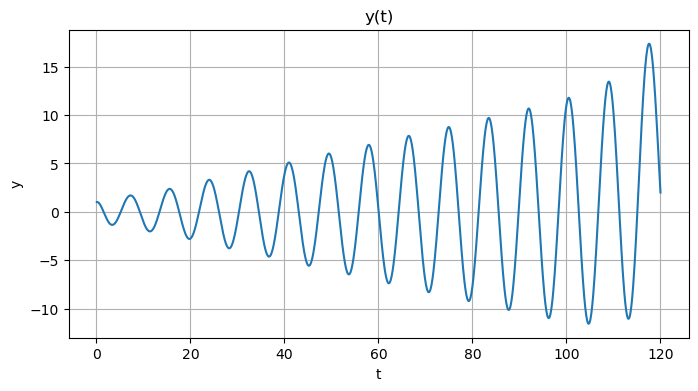

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルのパス
csv_path = "data/AC_waveform_data_11.5724.csv"

# データの読み込み
df = pd.read_csv(csv_path)

t_data = np.array(df.iloc[:, 0])[0:1200]
y_data = np.array(df.iloc[:, 1])[0:1200]

plt.figure(figsize=(8, 4))
plt.plot(t_data, y_data)
plt.xlabel('t')
plt.ylabel('y')
plt.title('y(t)')
plt.grid(True)
plt.show()

df = pd.read_csv("data/Reqnmn0.csv")
reqnmn0_data = np.array(df.iloc[:, 0])
df = pd.read_csv("data/Imqnmn0.csv")
imqnmn0_data = np.array(df.iloc[:, 0])
df = pd.read_csv("data/Reqnmn1.csv")
reqnmn1_data = np.array(df.iloc[:, 0])
df = pd.read_csv("data/Imqnmn1.csv")
imqnmn1_data = np.array(df.iloc[:, 0])
df = pd.read_csv("data/Reqnmn01average.csv")
reqnmn01average_data = np.array(df.iloc[:, 0])
df = pd.read_csv("data/Imqnmn01average.csv")
imqnmn01average_data = np.array(df.iloc[:, 0])

# 減衰を打ち消す
damping_factor = 0.21444 # 0.21444 # 0.19 # 0.1779
damped_sinusoid_data = (np.exp(damping_factor * t_data))
y_data = np.multiply(damped_sinusoid_data, y_data)
plt.figure(figsize=(8, 4))
plt.plot(t_data, y_data)
plt.xlabel('t')
plt.ylabel('y')
plt.title('y(t)')
plt.grid(True)
# plt.show()
# plt.savefig("resonance.png")


## Curve Fit (2QNM)

フィッティングで得られた最適パラメータ:
      A1: 0.9735
 lambda1: -1.5385
  omega1: 1.8715
    phi1: 0.2435
      A2: 0.7204
 lambda2: -0.9273
  omega2: 0.8344
    phi2: 0.3278


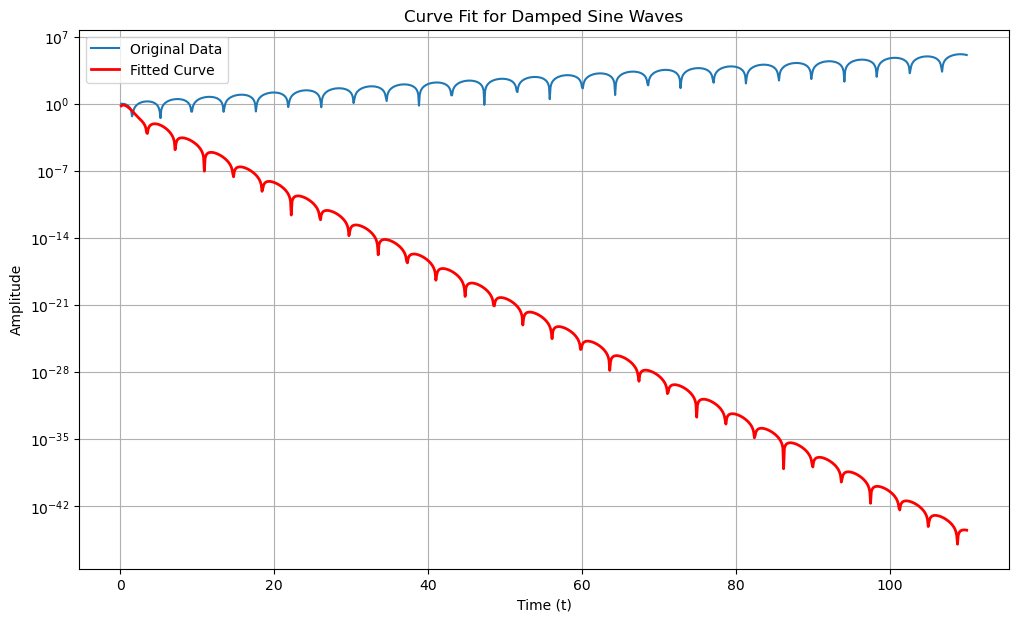

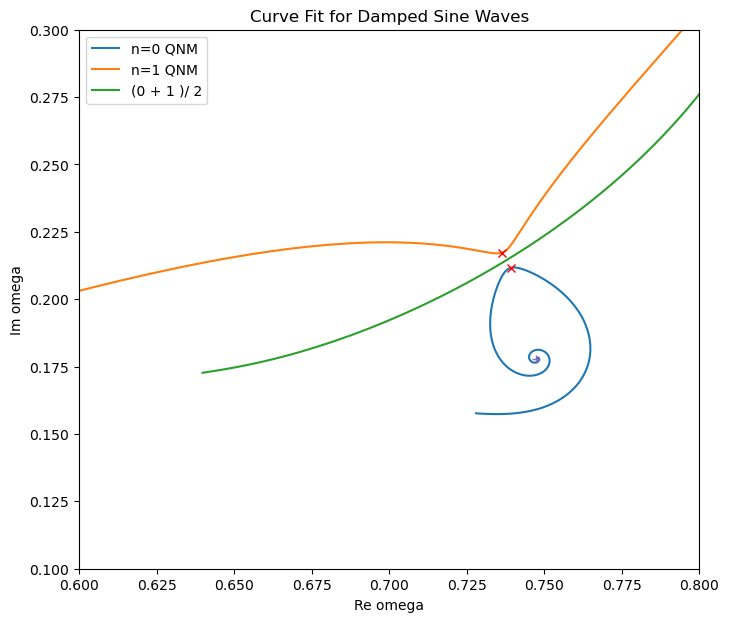

In [32]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fit_func(t, A1, lambda1, omega1, phi1, A2, lambda2, omega2, phi2):
    """
    フィッティング対象の関数：2つの減衰正弦波の和
    f(t) = A1*exp(lambda1*t)*sin(omega1*t+phi1) + A2*exp(lambda2*t)*sin(omega2*t+phi2)
    """
    term1 = A1 * np.exp(lambda1 * t) * np.sin(omega1 * t + phi1)
    term2 = A2 * np.exp(lambda2 * t) * np.sin(omega2 * t + phi2)
    return term1 + term2

# --- 1. データの準備 ---
# (オプション) サンプルデータの生成
# 実際には、この部分をご自身のデータ読み込み処理に置き換えてください。
# # 例: t_data, y_data = np.loadtxt('my_waveform_data.csv', delimiter=',', unpack=True)
# p_true = [1.5, -0.1, 5.0, np.pi/4, 1.0, -0.2, 12.0, np.pi/2] # 真のパラメータ
# t_data = np.linspace(0, 20, 500)
# # ノイズを加えた実データ（のつもり）
# y_data = fit_func(t_data, *p_true) + 0.15 * np.random.normal(size=t_data.size)


# --- 2. カーブフィッティングの実行 ---
# パラメータの初期推測値 (p0)
# 良い初期値を与えることがフィッティング成功の鍵となります。
# データを見て、おおよその値を推測します。
initial_guess = [
    1.0,  # A1
    # -0.2116451411183, # lambda1
    # 0.7391984327078,  # omega1
    - 0.17792, # lambda1
    0.74734,  # omega1
    0,    # phi1
    0.8,  # A2
    # -0.217234709569, # lambda2
    # 0.736312554, # omega2
    -0.54783, # lambda2
    0.693422, # omega2
    0     # phi2
]

# パラメータの境界 (bounds) を設定 (オプションですが推奨)
# A > 0, lambda < 0 など、物理的な制約を設けることで収束しやすくなります。
bounds = (
    [0, -np.inf, 0, -2*np.pi, 0, -np.inf, 0, -2*np.pi], # 下限
    [np.inf, 0, np.inf, 2*np.pi, np.inf, 0, np.inf, 2*np.pi]  # 上限
)

try:
    # curve_fit を実行
    popt, pcov = curve_fit(
        fit_func,
        t_data,
        y_data,
        p0=initial_guess,
        bounds=bounds,
        maxfev=10000 # 計算回数の上限を増やす
    )

    # --- 3. 結果の表示 ---
    print("フィッティングで得られた最適パラメータ:")
    param_names = ['A1', 'lambda1', 'omega1', 'phi1', 'A2', 'lambda2', 'omega2', 'phi2']
    for name, value in zip(param_names, popt):
        print(f"{name:>8s}: {value:.4f}")

    # --- 4. 結果のプロット ---
    plt.figure(figsize=(12, 7))
    plt.semilogy(t_data, np.abs(y_data), label='Original Data')
    plt.semilogy(t_data, np.abs(fit_func(t_data, *popt)), label='Fitted Curve', color='red', linewidth=2)
    plt.title('Curve Fit for Damped Sine Waves')
    plt.xlabel('Time (t)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

except RuntimeError as e:
    print(f"フィッティングに失敗しました: {e}")
    print("初期推測値(p0)や境界(bounds)を見直してください。")

reqnm = [abs(popt[2]), abs(popt[6])]
imqnm = [abs(popt[1]-damping_factor), abs(popt[5]-damping_factor)]
fig=  plt.figure(figsize=(8, 7))
plt.plot(reqnmn0_data, imqnmn0_data, label='n=0 QNM')
plt.plot(reqnmn1_data, imqnmn1_data, label='n=1 QNM')
plt.plot(reqnmn01average_data, imqnmn01average_data, label="(0 + 1 )/ 2")
plt.plot(reqnm, imqnm, 'o')
plt.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x', c='red')
plt.plot([initial_guess[2], initial_guess[6]], [-initial_guess[1], -initial_guess[6]], '+')
plt.xlim(0.6, 0.8)
plt.ylim(0.10, 0.3)
plt.title(f'Curve Fit for Damped Sine Waves')
plt.xlabel('Re omega')      
plt.ylabel('Im omega') 
plt.legend()

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import shutil

# 1. アニメーションのパラメータ設定
num_frames = 100  # フレーム数
frame_duration = 10  # 各フレームの表示時間（ミリ秒）
deltai = 10

# 2. フレームを保存するディレクトリの作成
output_dir = "animation_frames"
os.makedirs(output_dir, exist_ok=True)

# 解決策 1: 結果を保存するための空のリストを初期化
reqnm_history1 = []
imqnm_history1 = []
reqnm_history2 = []
imqnm_history2 = []

# 3. 各フレームの画像を生成して保存
print("Generating frames...")
for i in range(num_frames):

    try:
        # curve_fit を実行
        popt, pcov = curve_fit(
            fit_func,
            t_data[deltai*i:],
            y_data[deltai*i:],
            p0=initial_guess,
            bounds=bounds,
            maxfev=10000 # 計算回数の上限を増やす
        )

        # initial_guess = popt  # 次のフレームの初期値として使用

        # --- 3. 結果の表示 ---
        # print("フィッティングで得られた最適パラメータ:")
        # param_names = ['A1', 'A2', 'A3', 'A4', 'lambda1', 'omega1']
        # for name, value in zip(param_names, popt):
        #     print(f"{name:>8s}: {value:.4f}")


        # --- 4. 結果のプロット ---
        # fig = plt.figure(figsize=(12, 7))
        # plt.semilogy(t_data, np.abs(y_data), label='Original Data')
        # plt.semilogy(t_data, np.abs(fit_func(t_data, *popt)), label='Fitted Curve', color='red', linewidth=2)
        # plt.title(f'Curve Fit for Damped Sine Waves - Frame {t_data[10*i-1]}')
        # plt.xlabel('Time (t)')
        # plt.ylabel('Amplitude')
        # plt.legend()
        # plt.grid(True)
        # # plt.show()
        # # ファイル名を設定
        # # 0埋めすることで、Pillowが正しい順序で画像を読み込むようにする
        # frame_filename = os.path.join(output_dir, f"frame_{i:04d}.png")
        # plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        # plt.close(fig) # メモリを解放するために図を閉じる
        # if (i + 1) % 10 == 0:
        #     print(f"  {i+1} frames generated...")

        reqnm_history1.append(abs(popt[2]))
        imqnm_history1.append(abs(popt[1]-damping_factor))
        reqnm_history2.append(abs(popt[6]))
        imqnm_history2.append(abs(popt[5]-damping_factor))

        fig=  plt.figure(figsize=(8, 7))
        plt.plot(reqnm_history1, imqnm_history1, '-o', label='QNM Trajectory', alpha=0.4)
        plt.plot(reqnm_history2, imqnm_history2, '-o', label='QNM Trajectory', alpha=0.4)
        plt.plot(reqnmn0_data, imqnmn0_data, label='n=0 QNM')
        plt.plot(reqnmn1_data, imqnmn1_data, label='n=1 QNM')
        plt.plot(reqnmn01average_data, imqnmn01average_data, label="(0 + 1 )/ 2")
        # plt.plot(reqnm, imqnm, 'o')
        plt.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x', c='red')
        plt.plot([initial_guess[2], initial_guess[6]], [-initial_guess[1], -initial_guess[6]], '+', label='Initial Guess')
        plt.xlim(0.6, 0.8)
        plt.ylim(0.10, 0.3)
        plt.title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
        plt.xlabel('Re omega')      
        plt.ylabel('Im omega') 
        plt.legend(loc='upper right')
        # plt.xlim(0.72, 0.77)
        # plt.ylim(0.17, 0.23)
        frame_filename = os.path.join(output_dir, f"qnm_{i:04d}.png")
        plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        plt.close(fig) # メモリを解放するために図を閉じる
        if (i + 1) % 10 == 0:
            print(f"  {i+1} frames generated...")

        # # 解決策 2: 計算結果をリストに追加
        # reqnm_history1.append(abs(popt[2]))
        # imqnm_history1.append(abs(popt[1]))
        # reqnm_history2.append(abs(popt[6]))
        # imqnm_history2.append(abs(popt[5]))

        # reqnm = [abs(popt[2]), abs(popt[6])]
        # imqnm = [abs(popt[1]), abs(popt[5])]
        # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 18))
        # if y_data is not None:
        #     ax1.semilogy(t_data, np.abs(y_data), label='Original Data')
        # ax1.semilogy(t_data, np.abs(fit_func(t_data, *popt)), label='Fitted Curve', color='red', linewidth=2)
        # ax1.set_title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
        # ax1.set_xlabel('Time (t)')
        # ax1.set_ylabel('Amplitude')
        # ax1.legend()
        # ax1.grid(True)

        # ax2.plot(reqnm_history1, imqnm_history1, '-o', label='QNM Trajectory', alpha=0.4)
        # ax2.plot(reqnm_history2, imqnm_history2, '-o', label='QNM Trajectory', alpha=0.4)
        # ax2.plot(reqnm, imqnm, 'o')
        # ax2.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x', c='red')
        # ax2.plot([initial_guess[2], initial_guess[6]], [-initial_guess[1], -initial_guess[6]], '+')
        # ax2.set_xlim(0.6, 0.8)
        # ax2.set_ylim(0.10, 0.6)
        # ax2.set_title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
        # ax2.set_xlabel('Re omega')    
        # ax2.set_ylabel('Im omega') 
        # # plt.xlim(0.72, 0.77)
        # # plt.ylim(0.17, 0.23)
        # frame_filename = os.path.join(output_dir, f"qnm_{i:04d}.png")
        # plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        # plt.close(fig) # メモリを解放するために図を閉じる
        # if (i + 1) % 10 == 0:
        #     print(f"  {i+1} frames generated...")

    except RuntimeError as e:
        print(f"Frame {i+1} generation failed: {e}")
        continue

# 4. 生成した画像を読み込み、GIFアニメーションを作成
print("Creating GIF animation...")
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])

if not image_files:
    print("No PNG images found in the output directory. Animation cannot be created.")
else:
    images = []
    for filename in image_files:
        images.append(Image.open(filename))

    # 最初の画像を使って、残りの画像を結合
    if images:
        images[0].save(
            'animation_curve_fit_2QNM.gif',
            save_all=True,
            append_images=images[1:],
            duration=frame_duration,
            loop=0  # 0は無限ループ
        )
        print("Animation 'animation_curve_fit_2QNM.gif' created successfully!")
    else:
        print("No images were loaded for animation creation.")

# 5. 生成したフレーム画像を削除（オプション）
output_dir = "animation_frames"
if os.path.exists(output_dir):
    try:
        shutil.rmtree(output_dir)
        print(f"ディレクトリ '{output_dir}' を正常に削除しました。")
    except OSError as e:
        print(f"エラー: ディレクトリの削除に失敗しました。 {e.filename} - {e.strerror}.")
else:
    print(f"ディレクトリ '{output_dir}' が見つかりません。")

Generating frames...


IndexError: index 6 is out of bounds for axis 0 with size 6

## Curve Fit (linear model)

フィッティングで得られた最適パラメータ:
      A2: 5.7893
      A4: -5.9049
 lambda1: 0.0003
  omega1: 0.7345


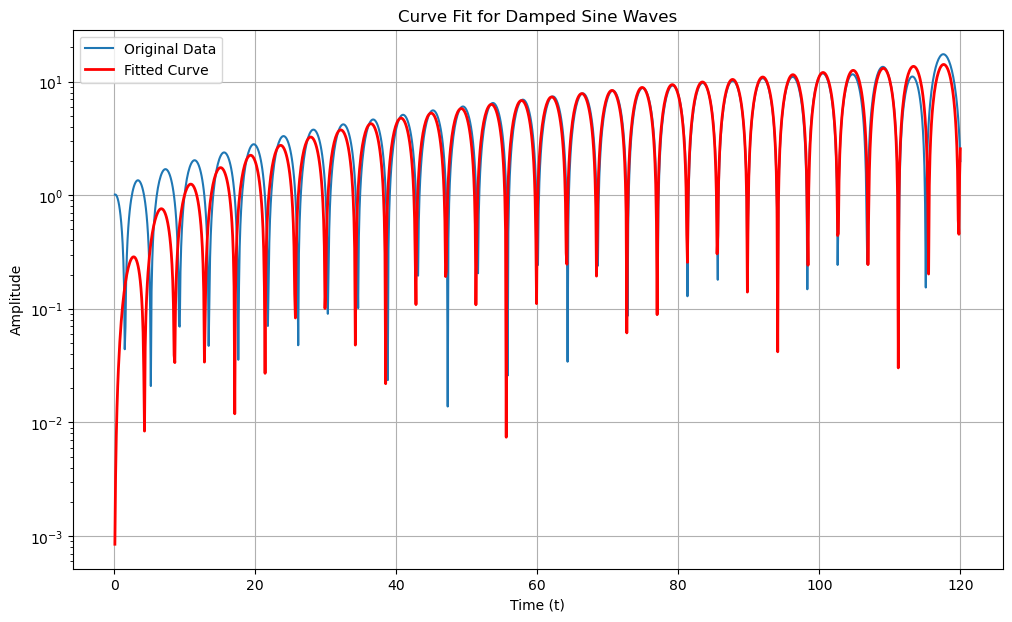

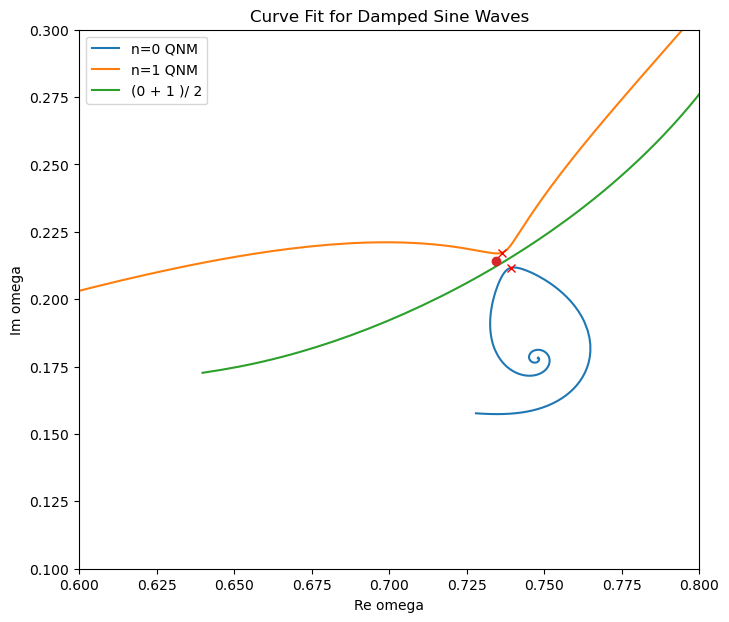

In [43]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fit_func(t, A2, A4, lambda1, omega1):
    return ( A2 * t ) * np.exp(lambda1 * t) * np.sin(omega1 * t ) + ( A4 * t ) * np.exp(lambda1 * t) * np.sin(omega1 * t ) 


# --- 2. カーブフィッティングの実行 ---
# パラメータの初期推測値 (p0)
# 良い初期値を与えることがフィッティング成功の鍵となります。
# データを見て、おおよその値を推測します。
initial_guess = [
    1.0,  # A2
    1.0,  # A4
    # - (0.21443992534365 - damping_factor), # lambda1
    # 0.737755493353,  # omega1
    - ( 0.1779 - damping_factor), # lambda1
    0.74734  # omega1
]
                                
# パラメータの境界 (bounds) を設定 (オプションですが推奨)
# A > 0, lambda < 0 など、物理的な制約を設けることで収束しやすくなります。
bounds = (
    [-np.inf, -np.inf, -np.inf, -2*np.pi,], # 下限
    [ np.inf, np.inf, np.inf, 2*np.pi]  # 上限
)

try:
    # curve_fit を実行
    popt, pcov = curve_fit(
        fit_func,
        t_data,
        y_data,
        p0=initial_guess,
        bounds=bounds,
        maxfev=10000 # 計算回数の上限を増やす
    )

    # --- 3. 結果の表示 ---
    print("フィッティングで得られた最適パラメータ:")
    param_names = ['A2', 'A4', 'lambda1', 'omega1']
    for name, value in zip(param_names, popt):
        print(f"{name:>8s}: {value:.4f}")

    # --- 4. 結果のプロット ---
    plt.figure(figsize=(12, 7))
    plt.semilogy(t_data, np.abs(y_data), label='Original Data')
    plt.semilogy(t_data, np.abs(fit_func(t_data, *popt)), label='Fitted Curve', color='red', linewidth=2)
    plt.title('Curve Fit for Damped Sine Waves')
    plt.xlabel('Time (t)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

except RuntimeError as e:
    print(f"フィッティングに失敗しました: {e}")
    print("初期推測値(p0)や境界(bounds)を見直してください。")

reqnm = [abs(popt[3])]
imqnm = [abs(popt[2]-damping_factor)]
fig=  plt.figure(figsize=(8, 7))
plt.plot(reqnmn0_data, imqnmn0_data, label='n=0 QNM')
plt.plot(reqnmn1_data, imqnmn1_data, label='n=1 QNM')
plt.plot(reqnmn01average_data, imqnmn01average_data, label="(0 + 1 )/ 2")
plt.plot(reqnm, imqnm, 'o')
plt.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x', c='red')
plt.xlim(0.6, 0.8)
plt.ylim(0.10, 0.3)
plt.title(f'Curve Fit for Damped Sine Waves')
plt.xlabel('Re omega')      
plt.ylabel('Im omega') 
plt.legend()
plt.savefig("resonance_2QNM.png", dpi=100)  # 保存する場合はコメントアウトを外す

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import shutil

# 1. アニメーションのパラメータ設定
num_frames = 100  # フレーム数
frame_duration = 10  # 各フレームの表示時間（ミリ秒）
deltai = 10

# 2. フレームを保存するディレクトリの作成
output_dir = "animation_frames"
os.makedirs(output_dir, exist_ok=True)

# 解決策 1: 結果を保存するための空のリストを初期化
reqnm_history = []
imqnm_history = []

# 3. 各フレームの画像を生成して保存
print("Generating frames...")
for i in range(num_frames):

    try:
        # curve_fit を実行
        popt, pcov = curve_fit(
            fit_func,
            t_data[deltai*i:],
            y_data[deltai*i:],
            p0=initial_guess,
            bounds=bounds,
            maxfev=10000 # 計算回数の上限を増やす
        )

        # initial_guess = popt  # 次のフレームの初期値として使用

        # --- 3. 結果の表示 ---
        # print("フィッティングで得られた最適パラメータ:")
        # param_names = ['A1', 'A2', 'A3', 'A4', 'lambda1', 'omega1']
        # for name, value in zip(param_names, popt):
        #     print(f"{name:>8s}: {value:.4f}")


        # --- 4. 結果のプロット ---
        # fig = plt.figure(figsize=(12, 7))
        # plt.semilogy(t_data, np.abs(y_data), label='Original Data')
        # plt.semilogy(t_data, np.abs(fit_func(t_data, *popt)), label='Fitted Curve', color='red', linewidth=2)
        # plt.title(f'Curve Fit for Damped Sine Waves - Frame {t_data[10*i-1]}')
        # plt.xlabel('Time (t)')
        # plt.ylabel('Amplitude')
        # plt.legend()
        # plt.grid(True)
        # # plt.show()
        # # ファイル名を設定
        # # 0埋めすることで、Pillowが正しい順序で画像を読み込むようにする
        # frame_filename = os.path.join(output_dir, f"frame_{i:04d}.png")
        # plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        # plt.close(fig) # メモリを解放するために図を閉じる
        # if (i + 1) % 10 == 0:
        #     print(f"  {i+1} frames generated...")

        reqnm_history.append(abs(popt[3]))
        imqnm_history.append(abs(popt[2]-damping_factor))
        fig=  plt.figure(figsize=(8, 7))
        plt.plot(reqnm_history, imqnm_history, '-o', label='QNM Trajectory', alpha=0.4)
        plt.plot(reqnmn0_data, imqnmn0_data, label='n=0 QNM')
        plt.plot(reqnmn1_data, imqnmn1_data, label='n=1 QNM')
        plt.plot(reqnmn01average_data, imqnmn01average_data, label="(0 + 1 )/ 2")
        plt.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x', c='red')
        plt.plot([initial_guess[3]], [-initial_guess[2] + damping_factor], '+')
        plt.xlim(0.6, 0.8)
        plt.ylim(0.10, 0.3)
        plt.title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
        plt.xlabel('Re omega')      
        plt.ylabel('Im omega') 
        # plt.xlim(0.72, 0.77)
        # plt.ylim(0.17, 0.23)
        plt.legend()
        frame_filename = os.path.join(output_dir, f"qnm_{i:04d}.png")
        plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        plt.close(fig) # メモリを解放するために図を閉じる
        if (i + 1) % 10 == 0:
            print(f"  {i+1} frames generated...")

        # # 解決策 2: 計算結果をリストに追加
        # reqnm_history.append(abs(popt[5]))
        # imqnm_history.append(abs(popt[4]))

        # reqnm = [abs(popt[5])]
        # imqnm = [abs(popt[4])]
        # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 18))
        # if y_data is not None:
        #     ax1.semilogy(t_data, np.abs(y_data), label='Original Data')
        # ax1.semilogy(t_data, np.abs(fit_func(t_data, *popt)), label='Fitted Curve', color='red', linewidth=2)
        # ax1.set_title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
        # ax1.set_xlabel('Time (t)')
        # ax1.set_ylabel('Amplitude')
        # ax1.legend()
        # ax1.grid(True)

        # ax2.plot(reqnm_history, imqnm_history, 'o-', label='QNM Trajectory', alpha=0.4)
        # ax2.plot(reqnm, imqnm, 'o')
        # ax2.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x')
        # ax2.plot([initial_guess[5]], [-initial_guess[4]], '+')
        # ax2.set_xlim(0.6, 0.8)
        # ax2.set_ylim(0.10, 0.6)
        # ax2.set_title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
        # ax2.set_xlabel('Re omega')    
        # ax2.set_ylabel('Im omega') 
        # # plt.xlim(0.72, 0.77)
        # # plt.ylim(0.17, 0.23)
        # frame_filename = os.path.join(output_dir, f"qnm_{i:04d}.png")
        # plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        # plt.close(fig) # メモリを解放するために図を閉じる
        # if (i + 1) % 10 == 0:
        #     print(f"  {i+1} frames generated...")

    except RuntimeError as e:
        print(f"Frame {i+1} generation failed: {e}")
        continue

# 4. 生成した画像を読み込み、GIFアニメーションを作成
print("Creating GIF animation...")
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])

if not image_files:
    print("No PNG images found in the output directory. Animation cannot be created.")
else:
    images = []
    for filename in image_files:
        images.append(Image.open(filename))

    # 最初の画像を使って、残りの画像を結合
    if images:
        images[0].save(
            'animation_curve_fit_linearmodel.gif',
            save_all=True,
            append_images=images[1:],
            duration=frame_duration,
            loop=0  # 0は無限ループ
        )
        print("Animation 'animation.gif' created successfully!")
    else:
        print("No images were loaded for animation creation.")

# 5. 生成したフレーム画像を削除（オプション）
output_dir = "animation_frames"
if os.path.exists(output_dir):
    try:
        shutil.rmtree(output_dir)
        print(f"ディレクトリ '{output_dir}' を正常に削除しました。")
    except OSError as e:
        print(f"エラー: ディレクトリの削除に失敗しました。 {e.filename} - {e.strerror}.")
else:
    print(f"ディレクトリ '{output_dir}' が見つかりません。")

Generating frames...
  10 frames generated...
  20 frames generated...
  30 frames generated...
  40 frames generated...
  50 frames generated...
  60 frames generated...
  70 frames generated...
  80 frames generated...
  90 frames generated...
  100 frames generated...
Creating GIF animation...
Animation 'animation.gif' created successfully!
ディレクトリ 'animation_frames' を正常に削除しました。


## Curve Fit (Ac model)

フィッティングで得られた最適パラメータ:
      A1: -1.1687
      A2: -0.0000
      A3: -1.1687
      A4: -0.0000
 lambda1: 0.1015
  omega1: 0.7352


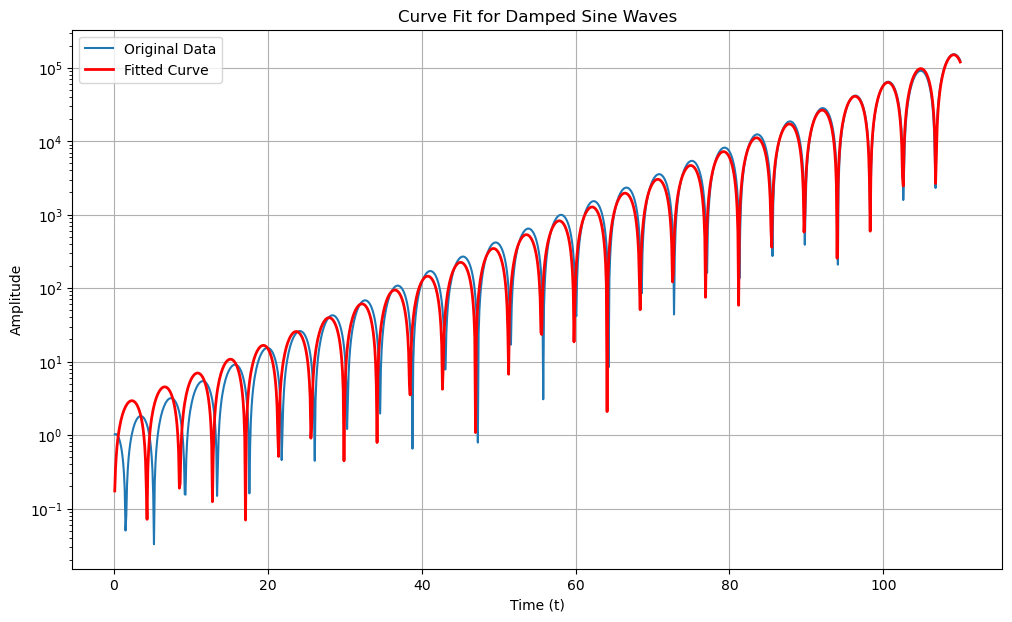

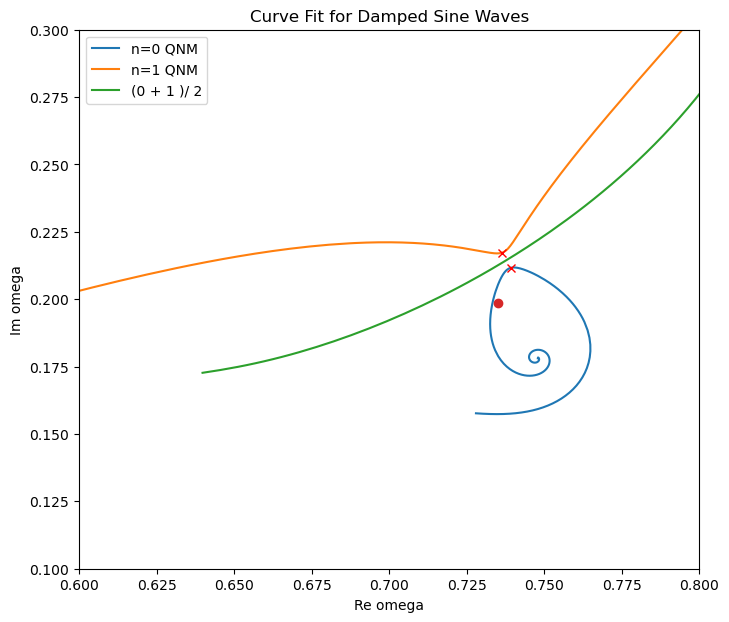

In [36]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fit_func(t, A1, A2, A3, A4, lambda1, omega1):
    """
    フィッティング対象の関数：2つの減衰正弦波の和
    f(t) = A1*exp(lambda1*t)*sin(omega1*t+phi1) + A2*exp(lambda2*t)*sin(omega2*t+phi2)
    """
    return (A1 + A2 * t ) * np.exp(lambda1 * t) * np.sin(omega1 * t ) + (A3 + A4 * t ) * np.exp(lambda1 * t) * np.sin(omega1 * t ) 


# --- 2. カーブフィッティングの実行 ---
# パラメータの初期推測値 (p0)
# 良い初期値を与えることがフィッティング成功の鍵となります。
# データを見て、おおよその値を推測します。
initial_guess = [
    1.0,  # A1
    1.0,  # A2
    1.0,  # A3
    1.0,  # A4
    - (0.21443992534365 - damping_factor), # lambda1
    0.737755493353,  # omega1
    # - ( 0.1779 - damping_factor), # lambda1
    # 0.74734  # omega1
]
                                
# パラメータの境界 (bounds) を設定 (オプションですが推奨)
# A > 0, lambda < 0 など、物理的な制約を設けることで収束しやすくなります。
bounds = (
    [-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -2*np.pi,], # 下限
    [np.inf, np.inf, np.inf, np.inf, np.inf, 2*np.pi]  # 上限
)

try:
    # curve_fit を実行
    popt, pcov = curve_fit(
        fit_func,
        t_data,
        y_data,
        p0=initial_guess,
        bounds=bounds,
        maxfev=10000 # 計算回数の上限を増やす
    )

    # --- 3. 結果の表示 ---
    print("フィッティングで得られた最適パラメータ:")
    param_names = ['A1', 'A2', 'A3', 'A4', 'lambda1', 'omega1']
    for name, value in zip(param_names, popt):
        print(f"{name:>8s}: {value:.4f}")

    # --- 4. 結果のプロット ---
    plt.figure(figsize=(12, 7))
    plt.semilogy(t_data, np.abs(y_data), label='Original Data')
    plt.semilogy(t_data, np.abs(fit_func(t_data, *popt)), label='Fitted Curve', color='red', linewidth=2)
    plt.title('Curve Fit for Damped Sine Waves')
    plt.xlabel('Time (t)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

except RuntimeError as e:
    print(f"フィッティングに失敗しました: {e}")
    print("初期推測値(p0)や境界(bounds)を見直してください。")

reqnm = [abs(popt[5])]
imqnm = [abs(popt[4]-damping_factor)]
fig=  plt.figure(figsize=(8, 7))
plt.plot(reqnmn0_data, imqnmn0_data, label='n=0 QNM')
plt.plot(reqnmn1_data, imqnmn1_data, label='n=1 QNM')
plt.plot(reqnmn01average_data, imqnmn01average_data, label="(0 + 1 )/ 2")
plt.plot(reqnm, imqnm, 'o')
plt.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x', c='red')
plt.xlim(0.6, 0.8)
plt.ylim(0.10, 0.3)
plt.title(f'Curve Fit for Damped Sine Waves')
plt.xlabel('Re omega')      
plt.ylabel('Im omega') 
plt.legend()

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import shutil

# 1. アニメーションのパラメータ設定
num_frames = 100  # フレーム数
frame_duration = 10  # 各フレームの表示時間（ミリ秒）
deltai = 10

# 2. フレームを保存するディレクトリの作成
output_dir = "animation_frames"
os.makedirs(output_dir, exist_ok=True)

# 解決策 1: 結果を保存するための空のリストを初期化
reqnm_history = []
imqnm_history = []

# 3. 各フレームの画像を生成して保存
print("Generating frames...")
for i in range(num_frames):

    try:
        # curve_fit を実行
        popt, pcov = curve_fit(
            fit_func,
            t_data[deltai*i:],
            y_data[deltai*i:],
            p0=initial_guess,
            bounds=bounds,
            maxfev=10000 # 計算回数の上限を増やす
        )

        # initial_guess = popt  # 次のフレームの初期値として使用

        # --- 3. 結果の表示 ---
        # print("フィッティングで得られた最適パラメータ:")
        # param_names = ['A1', 'A2', 'A3', 'A4', 'lambda1', 'omega1']
        # for name, value in zip(param_names, popt):
        #     print(f"{name:>8s}: {value:.4f}")


        # --- 4. 結果のプロット ---
        # fig = plt.figure(figsize=(12, 7))
        # plt.semilogy(t_data, np.abs(y_data), label='Original Data')
        # plt.semilogy(t_data, np.abs(fit_func(t_data, *popt)), label='Fitted Curve', color='red', linewidth=2)
        # plt.title(f'Curve Fit for Damped Sine Waves - Frame {t_data[10*i-1]}')
        # plt.xlabel('Time (t)')
        # plt.ylabel('Amplitude')
        # plt.legend()
        # plt.grid(True)
        # # plt.show()
        # # ファイル名を設定
        # # 0埋めすることで、Pillowが正しい順序で画像を読み込むようにする
        # frame_filename = os.path.join(output_dir, f"frame_{i:04d}.png")
        # plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        # plt.close(fig) # メモリを解放するために図を閉じる
        # if (i + 1) % 10 == 0:
        #     print(f"  {i+1} frames generated...")

        reqnm_history.append(abs(popt[5]))
        imqnm_history.append(abs(popt[4]-damping_factor))
        reqnm = [abs(popt[5])]
        imqnm = [abs(popt[4])]
        fig=  plt.figure(figsize=(8, 7))
        plt.plot(reqnm_history, imqnm_history, '-o', label='QNM Trajectory', alpha=0.4)
        plt.plot(reqnmn0_data, imqnmn0_data, label='n=0 QNM')
        plt.plot(reqnmn1_data, imqnmn1_data, label='n=1 QNM')
        plt.plot(reqnmn01average_data, imqnmn01average_data, label="(0 + 1 )/ 2")
        plt.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x', c='red')
        plt.plot([initial_guess[5]], [-initial_guess[4] + damping_factor], '+')
        plt.xlim(0.6, 0.8)
        plt.ylim(0.10, 0.3)
        plt.title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
        plt.xlabel('Re omega')      
        plt.ylabel('Im omega') 
        # plt.xlim(0.72, 0.77)
        # plt.ylim(0.17, 0.23)
        plt.legend()
        frame_filename = os.path.join(output_dir, f"qnm_{i:04d}.png")
        plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        plt.close(fig) # メモリを解放するために図を閉じる
        if (i + 1) % 10 == 0:
            print(f"  {i+1} frames generated...")

        # # 解決策 2: 計算結果をリストに追加
        # reqnm_history.append(abs(popt[5]))
        # imqnm_history.append(abs(popt[4]))

        # reqnm = [abs(popt[5])]
        # imqnm = [abs(popt[4])]
        # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 18))
        # if y_data is not None:
        #     ax1.semilogy(t_data, np.abs(y_data), label='Original Data')
        # ax1.semilogy(t_data, np.abs(fit_func(t_data, *popt)), label='Fitted Curve', color='red', linewidth=2)
        # ax1.set_title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
        # ax1.set_xlabel('Time (t)')
        # ax1.set_ylabel('Amplitude')
        # ax1.legend()
        # ax1.grid(True)

        # ax2.plot(reqnm_history, imqnm_history, 'o-', label='QNM Trajectory', alpha=0.4)
        # ax2.plot(reqnm, imqnm, 'o')
        # ax2.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x')
        # ax2.plot([initial_guess[5]], [-initial_guess[4]], '+')
        # ax2.set_xlim(0.6, 0.8)
        # ax2.set_ylim(0.10, 0.6)
        # ax2.set_title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
        # ax2.set_xlabel('Re omega')    
        # ax2.set_ylabel('Im omega') 
        # # plt.xlim(0.72, 0.77)
        # # plt.ylim(0.17, 0.23)
        # frame_filename = os.path.join(output_dir, f"qnm_{i:04d}.png")
        # plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        # plt.close(fig) # メモリを解放するために図を閉じる
        # if (i + 1) % 10 == 0:
        #     print(f"  {i+1} frames generated...")

    except RuntimeError as e:
        print(f"Frame {i+1} generation failed: {e}")
        continue

# 4. 生成した画像を読み込み、GIFアニメーションを作成
print("Creating GIF animation...")
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])

if not image_files:
    print("No PNG images found in the output directory. Animation cannot be created.")
else:
    images = []
    for filename in image_files:
        images.append(Image.open(filename))

    # 最初の画像を使って、残りの画像を結合
    if images:
        images[0].save(
            'animation_curve_fit_ACmodel.gif',
            save_all=True,
            append_images=images[1:],
            duration=frame_duration,
            loop=0  # 0は無限ループ
        )
        print("Animation 'animation.gif' created successfully!")
    else:
        print("No images were loaded for animation creation.")

# 5. 生成したフレーム画像を削除（オプション）
output_dir = "animation_frames"
if os.path.exists(output_dir):
    try:
        shutil.rmtree(output_dir)
        print(f"ディレクトリ '{output_dir}' を正常に削除しました。")
    except OSError as e:
        print(f"エラー: ディレクトリの削除に失敗しました。 {e.filename} - {e.strerror}.")
else:
    print(f"ディレクトリ '{output_dir}' が見つかりません。")

Generating frames...
  10 frames generated...
  20 frames generated...
  30 frames generated...
  40 frames generated...
  50 frames generated...
  60 frames generated...
  70 frames generated...
  80 frames generated...
  90 frames generated...
  100 frames generated...
Creating GIF animation...
Animation 'animation.gif' created successfully!
ディレクトリ 'animation_frames' を正常に削除しました。


## Varpro (2 QNM)

In [16]:
import numpy as np
from varpro import *

def examplePhiFunction(alpha,t):
    Phi = np.empty([t.shape[0],2])
    Phi[:,0] = np.multiply(np.exp(- alpha[0] * t),np.cos(alpha[1] * t + alpha[2]))
    Phi[:,1] = np.multiply(np.exp(- alpha[3] * t),np.cos(alpha[4] * t + alpha[5]))

    Ind = np.array([[0,0,0,1,1,1],[0,1,2,3,4,5]])
    
    dPhi = np.empty([t.shape[0],6])
    dPhi[:,0] = np.multiply(- np.ndarray.flatten(t),Phi[:,0])
    dPhi[:,1] = np.multiply(np.multiply(- t,np.exp(- alpha[0] * t)),np.sin(alpha[1] * t + alpha[2]))
    dPhi[:,2] = np.multiply(np.multiply(- 1,np.exp(- alpha[0] * t)),np.sin(alpha[1] * t + alpha[2]))
    dPhi[:,3] = np.multiply(- np.ndarray.flatten(t),Phi[:,1])
    dPhi[:,4] = np.multiply(np.multiply(- t,np.exp(- alpha[3] * t)),np.sin(alpha[4] * t + alpha[5]))
    dPhi[:,5] = np.multiply(np.multiply(- 1,np.exp(- alpha[3] * t)),np.sin(alpha[4] * t + alpha[5]))
    return Phi,dPhi,Ind

t = t_data[1:]
y = y_data[1:]
w = np.ones((len(t)))
# lambda0, omega0, phi0, lambda1, omega1, phi1 = 0.1, 0.7, 0.0, 0.3, 0.8, 0.1
# alphainit = np.array([0.1,0.7,0.0,0.3,0.8,3.14/2])
alphainit = np.array([0.17792, 0.74734,0.0,0.54783,0.693422,3.14/2])

alpha,c,wresid,resid_norm,y_est,CorMx,std_dev_params = varpro(t,y,w,alphainit,2,lambda alpha: examplePhiFunction(alpha,t))
print("lambda0=",alpha[0],"omega0=",alpha[1],"phi0=",alpha[2],"lambda1=",alpha[3],"omega1=",alpha[4],"phi1=",alpha[5])
print("A0=",c[0],"A1=",c[1])

def fit_func(t_data, c, alpha_list):
    """
    フィッティング対象の関数：2つの減衰正弦波の和
    f(t) = A1*exp(lambda1*t)*sin(omega1*t+phi1) + A2*exp(lambda2*t)*sin(omega2*t+phi2)
    """
    A1, A2 = c
    lambda1, omega1, phi1, lambda2, omega2, phi2 = alpha_list
    term1 = A1 * np.exp(-lambda1 * t_data) * np.cos(omega1 * t_data + phi1)
    term2 = A2 * np.exp(-lambda2 * t_data) * np.cos(omega2 * t_data + phi2)
    return term1 + term2
plt.figure(figsize=(12, 7))
plt.semilogy(t_data, np.abs(y_data), label='Original Data')
plt.semilogy(t_data, np.abs(fit_func(t_data, c, alpha)), label='Fitted Curve', color='red', linewidth=2)
plt.title('Curve Fit for Damped Sine Waves')
plt.xlabel('Time (t)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

reqnm = [abs(alpha[1]), abs(alpha[4])]
imqnm = [abs(alpha[0] + damping_factor), abs(alpha[3] + damping_factor)]
fig = plt.figure(figsize=(8, 6))
plt.plot(reqnm, imqnm, 'o')
plt.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x')
plt.plot([alphainit[1], alphainit[4]], [alphainit[0], alphainit [3]], '+')
plt.xlim(0.6, 0.8)
plt.ylim(0.10, 0.3)
plt.title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
plt.xlabel('Re omega')    
plt.ylabel('Im omega') 
plt.show() # メモリを解放するために図を閉じる

RankError: 
The linear parameters are not well-determined.
The rank of the matrix in the subproblem is 1,
which is less than the number of linear parameters (2).

Linear parameters:
    -1.8596431312547235e-34 -1.8123828894277224e-15
Nonlinear parameters:
    0.05554311813970489 0.9316100374829334 -1.3924346932460783 -0.2871822956283624 0.8732688240820506 5.16228270261763

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import numpy as np
from varpro import *
import shutil

# 1. アニメーションのパラメータ設定
num_frames = 100  # フレーム数
frame_duration = 10  # 各フレームの表示時間（ミリ秒）
deltai = 1

# 2. フレームを保存するディレクトリの作成
output_dir = "animation_frames"
os.makedirs(output_dir, exist_ok=True)

# 2. Def fit
def examplePhiFunction(alpha,t):
    Phi = np.empty([t.shape[0],2])
    Phi[:,0] = np.multiply(np.exp(- alpha[0] * t),np.cos(alpha[1] * t + alpha[2]))
    Phi[:,1] = np.multiply(np.exp(- alpha[3] * t),np.cos(alpha[4] * t + alpha[5]))

    Ind = np.array([[0,0,0,1,1,1],[0,1,2,3,4,5]])
    
    dPhi = np.empty([t.shape[0],6])
    dPhi[:,0] = np.multiply(- np.ndarray.flatten(t),Phi[:,0])
    dPhi[:,1] = np.multiply(np.multiply(- t,np.exp(- alpha[0] * t)),np.sin(alpha[1] * t + alpha[2]))
    dPhi[:,2] = np.multiply(np.multiply(- 1,np.exp(- alpha[0] * t)),np.sin(alpha[1] * t + alpha[2]))
    dPhi[:,3] = np.multiply(- np.ndarray.flatten(t),Phi[:,1])
    dPhi[:,4] = np.multiply(np.multiply(- t,np.exp(- alpha[3] * t)),np.sin(alpha[4] * t + alpha[5]))
    dPhi[:,5] = np.multiply(np.multiply(- 1,np.exp(- alpha[3] * t)),np.sin(alpha[4] * t + alpha[5]))
    return Phi,dPhi,Ind

# 解決策 1: 結果を保存するための空のリストを初期化
reqnm_history1 = []
imqnm_history1 = []
reqnm_history2 = []
imqnm_history2 = []

# 3. 各フレームの画像を生成して保存
print("Generating frames...")
# alphainit = np.array([0.17792,0.74734,0.0,0.54783,0.693422,3.14/2])
alphainit = np.array([0.17792, 0.74734,0.0,0.54783,0.693422,3.14/2])
for i in range(num_frames):

    try:
        t = t_data[deltai*i:]
        y = y_data[deltai*i:]
        w = np.ones((len(t)))
         # 解決策 2: 次のループのために初期値を更新する
        # alphainit = np.array([0.17792,0.74734,0.0,0.54783,0.693422,0.0])
        alpha,c,wresid,resid_norm,y_est,CorMx,std_dev_params = varpro(t,y,w,alphainit,2,lambda alpha: examplePhiFunction(alpha,t)) 
        
        alphainit = alpha  # 次のフレームの初期値として使用

        reqnm_history1.append(abs(alpha[1]))
        imqnm_history1.append(abs(alpha[0]))
        reqnm_history2.append(abs(alpha[4]))
        imqnm_history2.append(abs(alpha[3]))

        # # QNMをプロット 
        reqnm = [abs(alpha[1]), abs(alpha[4])]
        imqnm = [abs(alpha[0] + damping_factor), abs(alpha[3] + damping_factor)]
        fig = plt.figure(figsize=(8, 6))
        plt.plot(reqnmn0_data, imqnmn0_data, label='n=0 QNM')
        plt.plot(reqnmn1_data, imqnmn1_data, label='n=1 QNM')
        plt.plot(reqnmn01average_data, imqnmn01average_data, label="(0 + 1 )/ 2")
        plt.plot(reqnm_history1, imqnm_history1, '-o', alpha=0.4)
        plt.plot(reqnm_history2, imqnm_history2, '-o', alpha=0.4)
        plt.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x')
        plt.plot([alphainit[1], alphainit[4]], [alphainit[0]+ damping_factor, alphainit[3] + damping_factor], '+')
        plt.xlim(0.6, 0.8)
        plt.ylim(0.10, 0.3)
        plt.title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
        plt.xlabel('Re omega')    
        plt.ylabel('Im omega') 
        # plt.xlim(0.72, 0.77)
        # plt.ylim(0.17, 0.23)
        plt.legend()
        frame_filename = os.path.join(output_dir, f"qnm_{i:04d}.png")
        plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        plt.close(fig) # メモリを解放するために図を閉じる

        # # フィッティングの波形をプロット 
        # def fit_func(t_data, c, alpha_list):
        #     """
        #     フィッティング対象の関数：2つの減衰正弦波の和
        #     f(t) = A1*exp(lambda1*t)*sin(omega1*t+phi1) + A2*exp(lambda2*t)*sin(omega2*t+phi2)
        #     """
        #     A1, A2 = c
        #     lambda1, omega1, phi1, lambda2, omega2, phi2 = alpha_list
        #     term1 = A1 * np.exp(-lambda1 * t_data) * np.cos(omega1 * t_data + phi1)
        #     term2 = A2 * np.exp(-lambda2 * t_data) * np.cos(omega2 * t_data + phi2)
        #     return term1 + term2
        # fig = plt.figure(figsize=(12, 7))
        # plt.semilogy(t_data, np.abs(y_data), label='Original Data')
        # plt.semilogy(t_data, np.abs(fit_func(t_data, c, alpha)), label='Fitted Curve', color='red', linewidth=2)
        # plt.title('Curve Fit for Damped Sine Waves')
        # plt.xlabel('Time (t)')
        # plt.ylabel('Amplitude')
        # plt.legend()
        # plt.grid(True)
        # frame_filename = os.path.join(output_dir, f"qnm_{i:04d}.png")
        # plt.savefig(frame_filename, dpi=100) # dpiで解像度を設定
        # plt.close(fig) # メモリを解放するために図を閉じる

        if (i + 1) % 10 == 0:
            print(f"  {i+1} frames generated...")

    except RuntimeError as e:
        print(f"Frame {i+1} generation failed: {e}")
        continue

# 4. 生成した画像を読み込み、GIFアニメーションを作成
print("Creating GIF animation...")
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])

if not image_files:
    print("No PNG images found in the output directory. Animation cannot be created.")
else:
    images = []
    for filename in image_files:
        images.append(Image.open(filename))

    # 最初の画像を使って、残りの画像を結合
    if images:
        images[0].save(
            'animation_varpro_2QNM.gif',
            save_all=True,
            append_images=images[1:],
            duration=frame_duration,
            loop=0  # 0は無限ループ
        )
        print("Animation 'animation.gif' created successfully!")
    else:
        print("No images were loaded for animation creation.")

# 5. 生成したフレーム画像を削除（オプション）
output_dir = "animation_frames"
if os.path.exists(output_dir):
    try:
        shutil.rmtree(output_dir)
        print(f"ディレクトリ '{output_dir}' を正常に削除しました。")
    except OSError as e:
        print(f"エラー: ディレクトリの削除に失敗しました。 {e.filename} - {e.strerror}.")
else:
    print(f"ディレクトリ '{output_dir}' が見つかりません。")

Generating frames...
  10 frames generated...
  20 frames generated...
  30 frames generated...
  40 frames generated...
  50 frames generated...
  60 frames generated...
  70 frames generated...
  80 frames generated...
  90 frames generated...
  100 frames generated...
Creating GIF animation...
Animation 'animation.gif' created successfully!
ディレクトリ 'animation_frames' を正常に削除しました。


## Varpro (4 QNM)

In [ ]:
import numpy as np
from varpro import *

def examplePhiFunction(alpha,t):
    Phi = np.empty([t.shape[0],4])
    Phi[:,0] = np.multiply(np.exp(- alpha[0] * t),np.cos(alpha[1] * t + alpha[2]))
    Phi[:,1] = np.multiply(np.exp(- alpha[3] * t),np.cos(alpha[4] * t + alpha[5]))
    Phi[:,2] = np.multiply(np.exp(- alpha[6] * t),np.cos(alpha[7] * t + alpha[8]))
    Phi[:,3] = np.multiply(np.exp(- alpha[9] * t),np.cos(alpha[10] * t + alpha[11]))

    Ind = np.array([[0,0,0,1,1,1,2,2,2,3,3,3],[0,1,2,3,4,5,6,7,8,9,10,11]])
    
    dPhi = np.empty([t.shape[0],12])
    dPhi[:,0] = np.multiply(- np.ndarray.flatten(t),Phi[:,0])
    dPhi[:,1] = np.multiply(np.multiply(- t,np.exp(- alpha[0] * t)),np.sin(alpha[1] * t + alpha[2]))
    dPhi[:,2] = np.multiply(np.multiply(- 1,np.exp(- alpha[0] * t)),np.sin(alpha[1] * t + alpha[2]))
    dPhi[:,3] = np.multiply(- np.ndarray.flatten(t),Phi[:,1])
    dPhi[:,4] = np.multiply(np.multiply(- t,np.exp(- alpha[3] * t)),np.sin(alpha[4] * t + alpha[5]))
    dPhi[:,5] = np.multiply(np.multiply(- 1,np.exp(- alpha[3] * t)),np.sin(alpha[4] * t + alpha[5]))
    dPhi[:,6] = np.multiply(- np.ndarray.flatten(t),Phi[:,2])
    dPhi[:,7] = np.multiply(np.multiply(- t,np.exp(- alpha[6] * t)),np.sin(alpha[7] * t + alpha[8]))
    dPhi[:,8] = np.multiply(np.multiply(- 1,np.exp(- alpha[6] * t)),np.sin(alpha[7] * t + alpha[8]))
    dPhi[:,9] = np.multiply(- np.ndarray.flatten(t),Phi[:,3])
    dPhi[:,10] = np.multiply(np.multiply(- t,np.exp(- alpha[9] * t)),np.sin(alpha[10] * t + alpha[11]))
    dPhi[:,11] = np.multiply(np.multiply(- 1,np.exp(- alpha[9] * t)),np.sin(alpha[10] * t + alpha[11]))
    return Phi,dPhi,Ind

t = t_data[1:]
y = y_data[1:]
w = np.ones((len(t)))
# lambda0, omega0, phi0, lambda1, omega1, phi1 = 0.1, 0.7, 0.0, 0.3, 0.8, 0.1
# alphainit = np.array([0.1,0.7,0.0,0.3,0.8,3.14/2])
alphainit = np.array([0.17792,0.74734,0.0, 0.54783,0.693422,3.14/2, 0.956554, 0.602107,0.0, 1.410296, 0.503010, 0.0])

alpha,c,wresid,resid_norm,y_est,CorMx,std_dev_params = varpro(t,y,w,alphainit,4,lambda alpha: examplePhiFunction(alpha,t))
print("lambda0=",alpha[0],"omega0=",alpha[1],"phi0=",alpha[2],"lambda1=",alpha[3],"omega1=",alpha[4],"phi1=",alpha[5],"lambda2=",alpha[6],"omega2=",alpha[7],"phi2=",alpha[8],"lambda3=",alpha[9],"omega3=",alpha[10],"phi3=",alpha[11])
print("A0=",c[0],"A1=",c[1],"A2=",c[2],"A3=",c[3])

def fit_func(t_data, c, alpha_list):
    A1, A2, A3, A4 = c
    lambda1, omega1, phi1, lambda2, omega2, phi2, lambda3, omega3, phi3, lambda4, omega4, phi4 = alpha_list
    term1 = A1 * np.exp(-lambda1 * t_data) * np.cos(omega1 * t_data + phi1)
    term2 = A2 * np.exp(-lambda2 * t_data) * np.cos(omega2 * t_data + phi2)
    term3 = A3 * np.exp(-lambda3 * t_data) * np.cos(omega3 * t_data + phi3)
    term4 = A4 * np.exp(-lambda4 * t_data) * np.cos(omega4 * t_data + phi4)
    return term1 + term2 + term3 + term4
plt.figure(figsize=(12, 7))
plt.semilogy(t_data, np.abs(y_data), label='Original Data')
plt.semilogy(t_data, np.abs(fit_func(t_data, c, alpha)), label='Fitted Curve', color='red', linewidth=2)
plt.title('Curve Fit for Damped Sine Waves')
plt.xlabel('Time (t)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

reqnm = [abs(alpha[1]), abs(alpha[4]), abs(alpha[7]), abs(alpha[10])]
imqnm = [abs(alpha[0]), abs(alpha[3]), abs(alpha[6]), abs(alpha[9])]
fig = plt.figure(figsize=(8, 6))
plt.plot(reqnm, imqnm, 'o', label='fit')
plt.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x', label='true QNM')
plt.plot([alphainit[1], alphainit[4]], [alphainit[0], alphainit [3]], '+', label='initial guess')
plt.xlim(0.6, 0.8)
plt.ylim(0.10, 0.3)
plt.title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
plt.xlabel('Re omega')    
plt.ylabel('Im omega') 
plt.legend()
plt.show() # メモリを解放するために図を閉じる

RankError: 
The linear parameters are not well-determined.
The rank of the matrix in the subproblem is 1,
which is less than the number of linear parameters (4).

Linear parameters:
    -4.976222854148194e-40 -6.209288465282121e-22 -1.2884822396436553e-41 -1.6349458084459681e-41
Nonlinear parameters:
    0.04142058727624934 0.9284419190536224 -1.2692498167269513 -0.3838037470910679 0.6041803021897496 1.536511405509433 2.228547001235643 -0.0856599637049279 -0.6710860361792468 0.7158588146908983 -0.6776630053072135 -0.6312501377619592

## Varpro (AC model)

In [ ]:
import numpy as np
from varpro import *

def examplePhiFunction(alpha,t):
    Phi = np.empty([t.shape[0],4])
    Phi[:,0] = np.multiply(np.exp(- alpha[0] * t),np.cos(alpha[1] * t))
    Phi[:,1] = np.multiply(t,np.exp(- alpha[0] * t),np.cos(alpha[1] * t ))
    Phi[:,2] = np.multiply(np.exp(- alpha[0] * t),np.sin(alpha[1] * t))
    Phi[:,3] = np.multiply(t,np.exp(- alpha[0] * t),np.sin(alpha[1] * t ))

    Ind = np.array([[0,0,1,1,2,2,3,3],[0,1,0,1,0,1,0,1]])
    
    dPhi = np.empty([t.shape[0],8])
    # alpha[0] (lambda) に関する微分
    dPhi[:,0] = np.multiply(- np.ndarray.flatten(t),Phi[:,0])  # d/dlambda[exp(-lambda*t)*cos(omega*t)]
    dPhi[:,2] = np.multiply(- np.ndarray.flatten(t),Phi[:,1])  # d/dlambda[t*exp(-lambda*t)*cos(omega*t)]
    dPhi[:,4] = np.multiply(- np.ndarray.flatten(t),Phi[:,2])  # d/dlambda[exp(-lambda*t)*sin(omega*t)]
    dPhi[:,6] = np.multiply(- np.ndarray.flatten(t),Phi[:,3])  # d/dlambda[t*exp(-lambda*t)*sin(omega*t)]
    
    # alpha[1] (omega) に関する微分
    dPhi[:,1] = np.multiply(- np.ndarray.flatten(t),np.exp(- alpha[0] * t) * np.sin(alpha[1] * t))  # d/domega[exp(-lambda*t)*cos(omega*t)]
    dPhi[:,3] = np.multiply(- np.ndarray.flatten(t),np.ndarray.flatten(t) * np.exp(- alpha[0] * t) * np.sin(alpha[1] * t))  # d/domega[t*exp(-lambda*t)*cos(omega*t)]
    dPhi[:,5] = np.multiply(t * np.exp(- alpha[0] * t),np.cos(alpha[1] * t))  # d/domega[exp(-lambda*t)*sin(omega*t)]
    dPhi[:,7] = t * t * np.exp(- alpha[0] * t) * np.cos(alpha[1] * t)   # d/domega[t*exp(-lambda*t)*sin(omega*t)]
    return Phi,dPhi,Ind

t = t_data[1:]
y = y_data[1:]
w = np.ones((len(t)))
# lambda0, omega0, phi0, lambda1, omega1, phi1 = 0.1, 0.7, 0.0
# alphainit = np.array([0.17792,0.74734])
alphainit = np.array([0.15, 0.74])

alpha,c,wresid,resid_norm,y_est,CorMx,std_dev_params = varpro(t,y,w,alphainit,4,lambda alpha: examplePhiFunction(alpha,t))
print("lambda0=",alpha[0],"omega0=",alpha[1])
print("A0=",c[0],"A1=",c[1]," A2=",c[2]," A3=",c[3])

# def fit_func(t_data, c, alpha_list):
#     """
#     フィッティング対象の関数：2つの減衰正弦波の和
#     f(t) = A1*exp(lambda1*t)*sin(omega1*t+phi1) + A2*exp(lambda2*t)*sin(omega2*t+phi2)
#     """
#     A1, A2 = c
#     lambda1, omega1, phi1, lambda2, omega2, phi2 = alpha_list
#     term1 = A1 * np.exp(-lambda1 * t_data) * np.cos(omega1 * t_data + phi1)
#     term2 = A2 * np.exp(-lambda2 * t_data) * np.cos(omega2 * t_data + phi2)
#     return term1 + term2
# plt.figure(figsize=(12, 7))
# plt.semilogy(t_data, np.abs(y_data), label='Original Data')
# plt.semilogy(t_data, np.abs(fit_func(t_data, c, alpha)), label='Fitted Curve', color='red', linewidth=2)
# plt.title('Curve Fit for Damped Sine Waves')
# plt.xlabel('Time (t)')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid(True)
# plt.show()

reqnm = [abs(alpha[1])]
imqnm = [abs(alpha[0])]
fig = plt.figure(figsize=(8, 6))
plt.plot(reqnm, imqnm, 'o')
plt.plot([0.7391984327078, 0.736312554], [0.2116451411183, 0.217234709569], 'x')
plt.plot([alphainit[1]], [alphainit[0]], '+')
plt.xlim(0.6, 0.8)
plt.ylim(0.10, 0.3)
plt.title(f'Curve Fit for Damped Sine Waves - t_i = {t_data[deltai*i]}')
plt.xlabel('Re omega')    
plt.ylabel('Im omega') 
plt.show() # メモリを解放するために図を閉じる

RankError: 
The linear parameters are not well-determined.
The rank of the matrix in the subproblem is 3,
which is less than the number of linear parameters (4).

Linear parameters:
    0.9475434820687791 0.0046816626755283456 -0.587151924576553 0.00468166267552777
Nonlinear parameters:
    0.15 0.74